## Class Activation Map:

In this notebook we will see why a convnet classifies an image into a particular class, which parts of the image helped the convnet in identifying it's class, basically we will learn model explainability for convnets.

The technique we are going to see is Class Activation Map(CAM). 
> **CAM visualization consists of producing heatmaps of class activation over input images. A class activation map is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration.** 

**How it works?**

let's start with basics, Each convolutional layer in convnet is nothing but a stack of convolutional filters/kernels/channels, each of them meant to learn a particular feature from it's input feature map. A first convolution layer will learn small local patters such as edges, second layer will learn a bit complex features made of the first layer such as an eye and so on. Last convolution layer channels will learn large features such as face. Different channels will have different features learned and then we flatten them and pass to a classifier(mostly dense layers with softmax/sigmoid activation). 

Let's say we have only one dense layer with softmax activation and 2 target classes in our classifier. The dense layer will output probabilities for classes based on the features from last convolutional layer. Each channel from last conv layer will be wieghted differently by each node(class) in dense layer based on how important the feature learned by the channel is for that class. If we trace back to channels with high weights for a particular class(node of dense layer), our job is done!

Let's see how it's done in keras.


Import all required packages.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import tensorflow as tf
from IPython.display import Image
import cv2
import matplotlib.cm as cm
import os

We will use VGG16 pretrained model for our CAM demo. Let's load the model.

In [45]:
model = VGG16(weights='imagenet')

Let's load an image to work with.

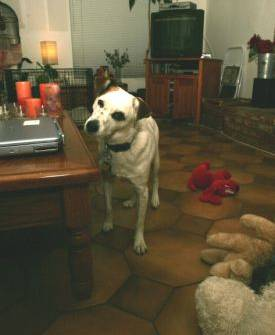

In [46]:
img_path = '../input/dogs-vs-cats/dataset/training_set/dogs/dog.1016.jpg'

display(Image(img_path))

Preprocess the image to transform into something that the model can accept.

In [47]:
img = image.load_img(img_path, target_size=(244,244)) #read image, resize image to 224,224
img = image.img_to_array(img) #convert it into a tensor
img = np.expand_dims(img, axis=0) #expand in first axis to make it's shape (1,244,244,3)
img = preprocess_input(img) #standard preprocessing

Let's predict the class using VGG16 model we loaded previously.

In [48]:
pred = model.predict(img)
print(decode_predictions(pred))
classIdx = np.argmax(pred)
(imagenetID, label, prob) = decode_predictions(pred)[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)

[[('n02099712', 'Labrador_retriever', 0.4992195), ('n02110341', 'dalmatian', 0.10037319), ('n02110958', 'pug', 0.08189034), ('n02111500', 'Great_Pyrenees', 0.03561915), ('n02093754', 'Border_terrier', 0.0205724)]]


So the model says it's a Dog(Labrador_retriever) with probability of 0.5. Let's find out the parts in input image which led the model to this classification decision.

Firstly, we need to know the model, what are the conv layers, classifier part. Let's print model summary.

In [49]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

So last conv layer in our model is "block5_conv3" and classifier consists of pooling layer, flatten layer and Dense layers.

In [50]:
last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    "block5_pool",
    "flatten",
    "fc1",
    "fc2",
    "predictions"
]


Let's find the heatmap for activations for this class(Labrador_retriever).

In [51]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

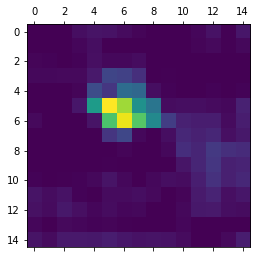

In [52]:
heatmap = make_gradcam_heatmap(
    img, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Let's create a superimposed visualization.

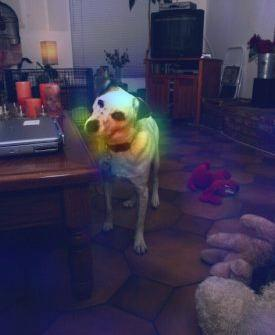

In [53]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "dog_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

References:

[https://keras.io/examples/vision/grad_cam/](https://keras.io/examples/vision/grad_cam/)